In [1]:
import timeit
import re
from pathlib import Path
# from itertools import product, ch

import sys
sys.path.append(str(Path.cwd().parent / "classes"))
sys.path.append(str(Path.cwd().parent))

import pandas as pd
from matplotlib import pyplot as plt

from sim_config import SimConfiguration
from simulation import Simulation
from msa import Msa


In [2]:
def scale_tree(tree_path: str, scale_factor: float, overwrite: bool=False):
    # Read the tree
    tree_path = Path(tree_path)

    with open(tree_path, 'r') as f:
        newick_str = f.read().strip()
    
    # Function to scale branch lengths in Newick string
    def scale_length(match):
        length = float(match.group(1))
        scaled = length * scale_factor
        return f":{scaled:.10f}"
    
    # Scale all branch lengths using regex
    scaled_newick = re.sub(r':([0-9.]+)', scale_length, newick_str)

    scaled_tree_path = (tree_path.parent / f"scaled_{scale_factor}.tree") if not overwrite else tree_path
    # Write the scaled tree directly
    with open(scaled_tree_path, 'w') as f:
        f.write(scaled_newick)
    return scaled_tree_path

[(0.01, 0.09),
 (0.02, 0.08),
 (0.03, 0.07),
 (0.04, 0.06),
 (0.05, 0.05),
 (0.06, 0.04),
 (0.07, 0.03),
 (0.08, 0.02),
 (0.09, 0.01)]

In [3]:
ROOT_SEQUENCE_LENGTH = 1000

TREES_PATH = Path.cwd() / "TRUE_TREES"
time_winners = []
measured_times: list[list[float]] = []



def refresh_sim(tree_file, indel_rate):
    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=2.0,
                                indel_truncated_length=50,
                                rate_ins=indel_rate[0], rate_del=indel_rate[1],
                                deletion_extra_edge_length=50,
                                switch_factor=50,
                                seed=81)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)

    return sim

branches_dfs = []

NUMBER_OF_WINS = 4
stop_flag = NUMBER_OF_WINS

rates = [i*0.01 for i in range(1,10)]
rates = list(zip(rates, rates[::-1]))

for RATE_MULTIPLIER in range(1,20):#[0.5, 1,2,4,8,16]:
    for indel_rate in rates:
        factor_compare = {"branch_scale": [], 
                    "blocklist_time": [], "blocktree_time": [],
                    "true": [], "factor": [],
                    "insertion_rate": [indel_rate[0]], "deletion_rate": [indel_rate[1]]
                    }
        scaled_tree_path = scale_tree("/home/elyawy/temp/evo-sim/benchmark/scaled_trees/test_tree.txt", RATE_MULTIPLIER)

        sim = refresh_sim(scaled_tree_path, indel_rate)
        factor_compare["true"].append(len(sim.sim_nodes[1].list_of_events))
        factor_compare["factor"].append(sim.sim_nodes[1].hybrid_factor)

        blocktree_time = timeit.timeit(sim.msa_from_blocktree, number=5)
        blocklist_time = timeit.timeit(sim.msa_from_blocklist, number=5)
        factor_compare["blocklist_time"].append(blocklist_time)
        factor_compare["blocktree_time"].append(blocktree_time)
        factor_compare["branch_scale"].append(RATE_MULTIPLIER)
        comparison_df = pd.DataFrame(factor_compare)
        branches_dfs.append(comparison_df)
    # if blocktree_time < blocklist_time:
    #     stop_flag -= 1
    # else:
    #     stop_flag = NUMBER_OF_WINS
    # if stop_flag == 0:
    #     break
    # comparison_df.plot.scatter(x="factor",y="true")

In [5]:
branches_df = pd.concat(branches_dfs)
# branches_df[branches_df["blocklist_time"] > branches_df["blocktree_time"]]
branches_df.reset_index

<bound method DataFrame.reset_index of     branch_scale  blocklist_time  blocktree_time  true  factor  \
0              1        0.312278        0.429205     8    10.0   
0              1        0.286681        0.338481     8    10.0   
0              1        0.271216        0.316913     8    10.0   
0              1        0.258739        0.296125     8    10.0   
0              1        0.240264        0.292593     7    10.0   
..           ...             ...             ...   ...     ...   
0             19        0.845037        1.499694   187   190.0   
0             19        0.260033        0.533673   182   190.0   
0             19        0.171671        0.369029   171   190.0   
0             19        0.092765        0.203501   159   190.0   
0             19        0.073596        0.156244   152   190.0   

    insertion_rate  deletion_rate  
0             0.01           0.09  
0             0.02           0.08  
0             0.03           0.07  
0             0.04      

In [9]:
branches_df.reset_index(drop=True).to_csv("comparison.csv")

In [17]:
# branches_df = branches_df.reset_index(drop=True)
branches_df

,branch_scale,blocklist_time,blocktree_time,true,factor,insertion_rate,deletion_rate
0,1,0.312278,0.429205,8,10.0,0.01,0.09
1,1,0.286681,0.338481,8,10.0,0.02,0.08
2,1,0.271216,0.316913,8,10.0,0.03,0.07
3,1,0.258739,0.296125,8,10.0,0.04,0.06
4,1,0.240264,0.292593,7,10.0,0.05,0.05
...,...,...,...,...,...,...,...
166,19,0.845037,1.499694,187,190.0,0.05,0.05
167,19,0.260033,0.533673,182,190.0,0.06,0.04
168,19,0.171671,0.369029,171,190.0,0.07,0.03
169,19,0.092765,0.203501,159,190.0,0.08,0.02


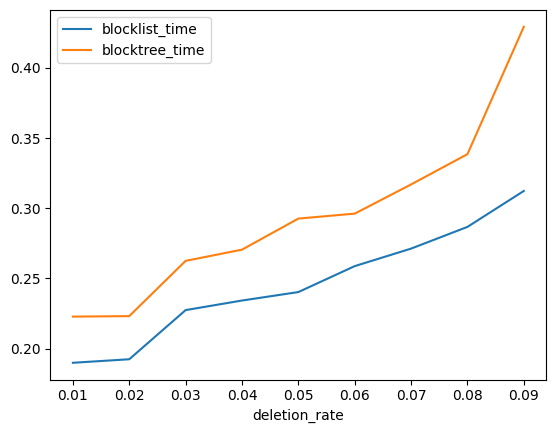

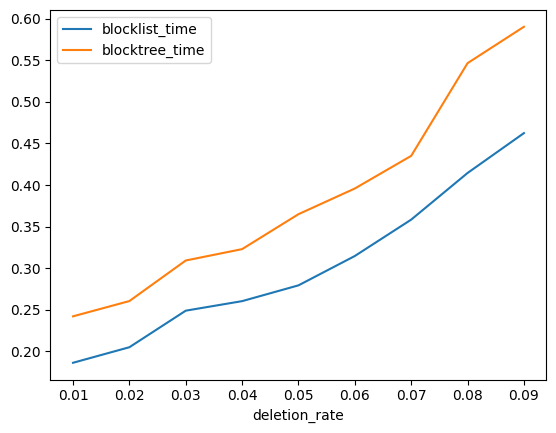

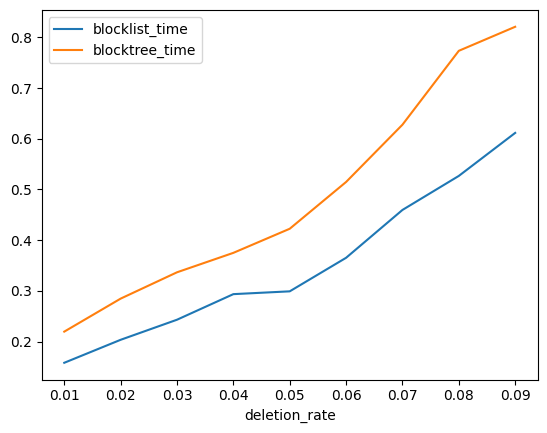

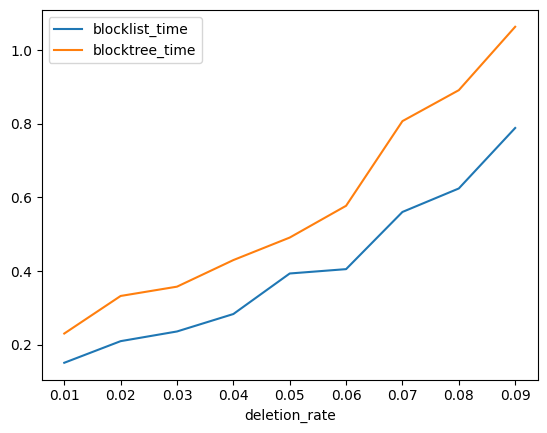

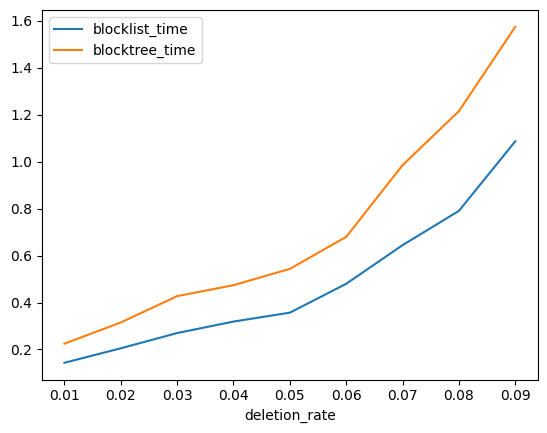

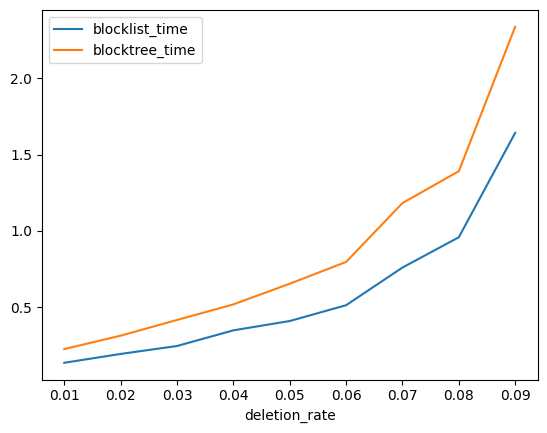

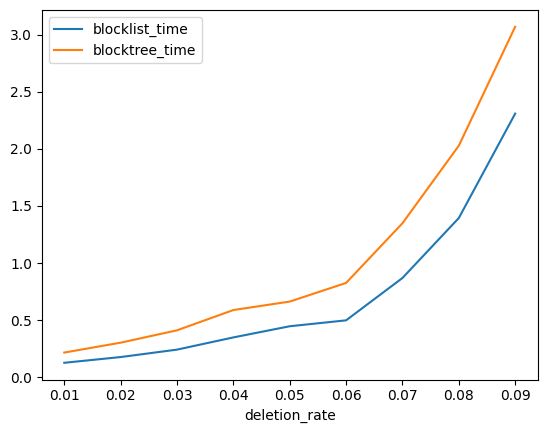

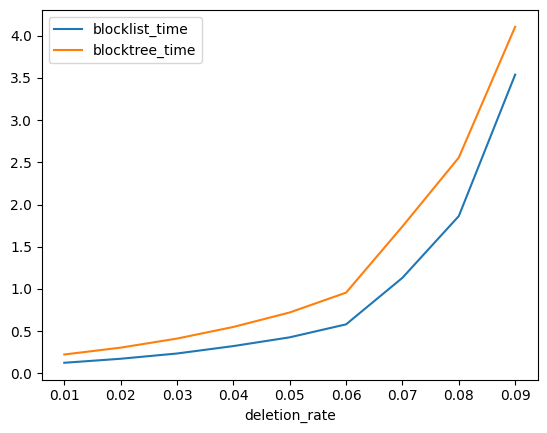

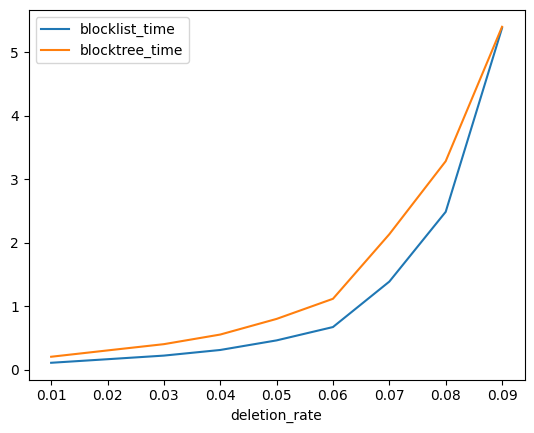

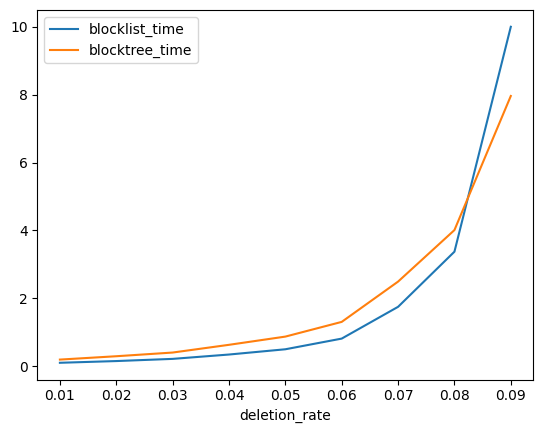

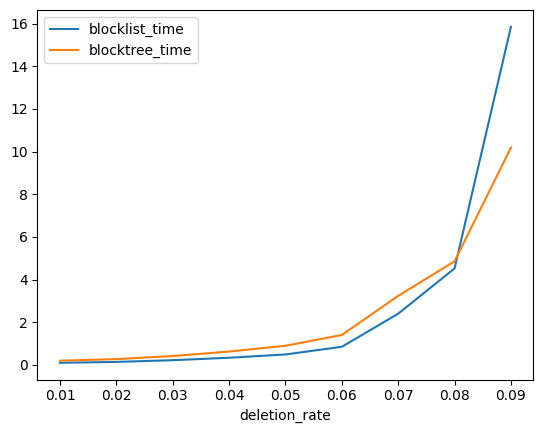

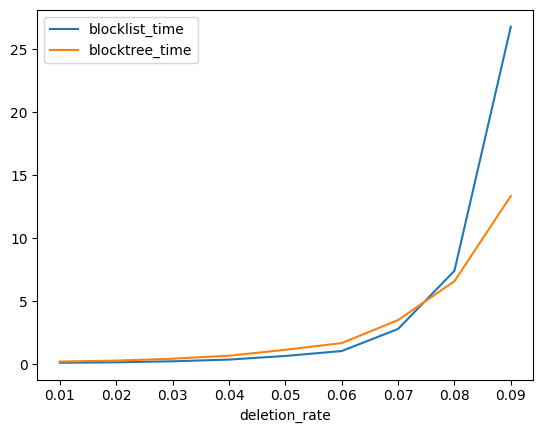

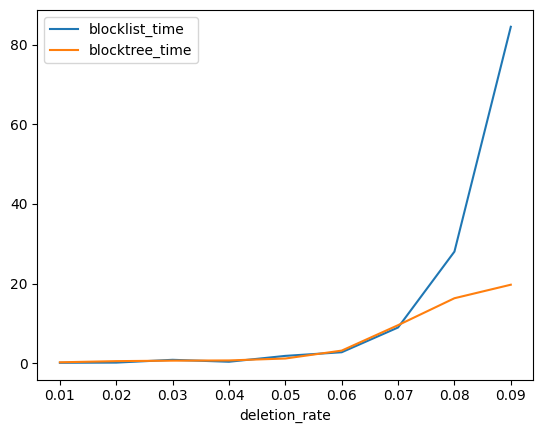

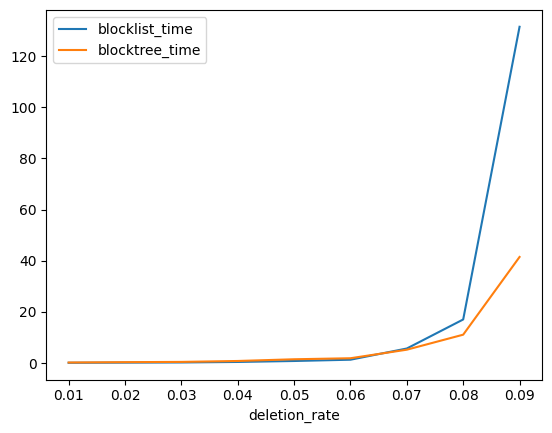

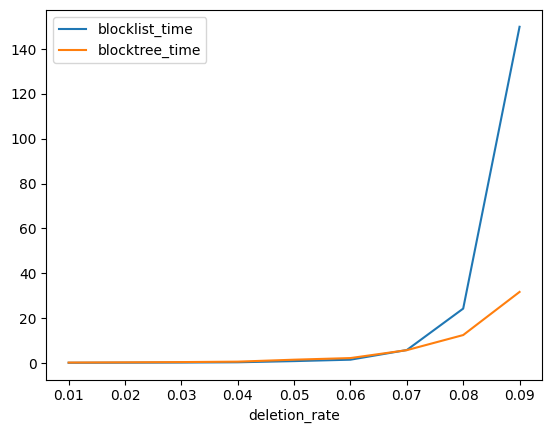

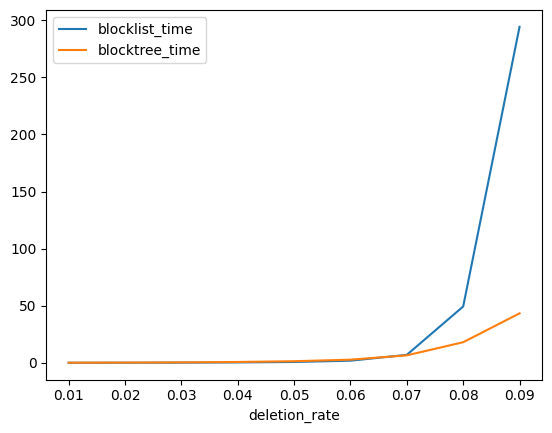

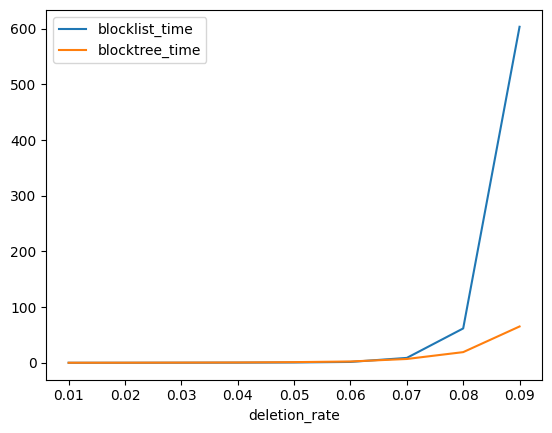

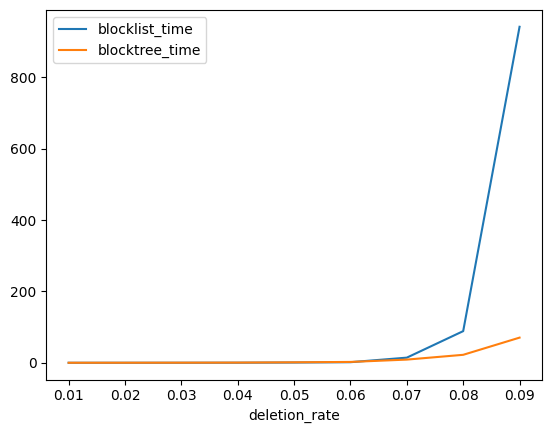

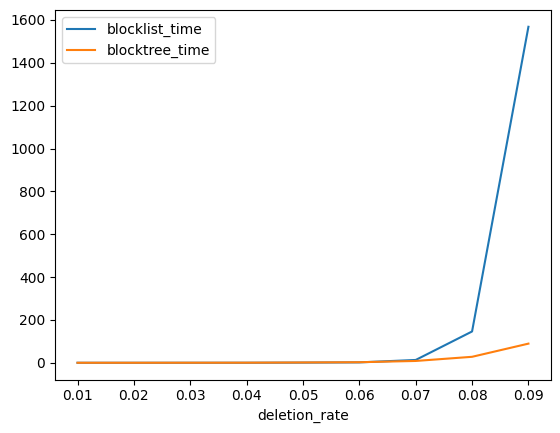

In [25]:
for group in branches_df.groupby("branch_scale"):
    group[1][["blocklist_time", "blocktree_time", "deletion_rate"]].plot(x ="deletion_rate")

In [37]:
comparison_df.corr()

,branch_scale,blocklist_time,blocktree_time,true,factor
branch_scale,NaN,NaN,NaN,NaN,NaN
blocklist_time,NaN,NaN,NaN,NaN,NaN
blocktree_time,NaN,NaN,NaN,NaN,NaN
true,NaN,NaN,NaN,NaN,NaN
factor,NaN,NaN,NaN,NaN,NaN


In [18]:
comparison_df["dist"] = (comparison_df.true - comparison_df.factor)**2

In [19]:
comparison_df.loc[comparison_df["dist"].argmax()]

true      17.000000
factor     9.581449
dist      55.034896
Name: 3, dtype: float64

In [22]:
a = -2.0

zipf_sum = sum([x**a for x in range(1,51)])
avg = sum([x*(x**a/zipf_sum) for x in range(1,51)])
avg

2.7685156081393822